# MNE-Python Analysis

### Import Packages

In [1]:
# Import needed packages

import mne
import numpy as np
import matplotlib

# import pathlib
# import matplotlib.pyplot as plt
# import scipy.signal as signal
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
# import mne_bids
# from mne_bids import BIDSPath, read_raw_bids
# import mne_bids.stats 
# import shutil
# from mpl_toolkits.mplot3d import Axes3D  # noqa
# from scipy.linalg import svd
# from mne.preprocessing import find_bad_channels_maxwell
# from copy import deepcopy
# import seaborn as sns
# import pandas as pd
# from mne.preprocessing import (create_eog_epochs, create_ecg_epochs, compute_proj_ecg, compute_proj_eog)
# import scipy
# from scipy.io import loadmat
# from mne.externals.pymatreader import read_mat

### Preprocessing

In [2]:
# Read the file

epochs = mne.read_epochs('epochs-epo.fif', preload=False)

Reading epochs-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     499.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated


In [3]:
# Load data and filter

epochs.load_data()
epochs = epochs.filter(l_freq=.1, h_freq=30)

Loading data for 477 events and 700 original time points ...
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33001 samples (33.001 sec)



<ipython-input-3-7abb2c38ae6f>:4: RuntimeWarning: filter_length (33001) is longer than the signal (700), distortion is likely. Reduce filter length or filter a longer signal.
  epochs = epochs.filter(l_freq=.1, h_freq=30)


### Visualise evoked responses

Not setting metadata
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


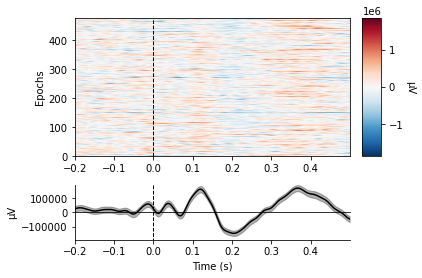

In [4]:
# Inspect activity traces averaged across all channels and epochs

%matplotlib inline

#All epochs
epochs.plot_image(combine='mean', show=True, title='');


## Averaged by coherence levels

# epochs['1'].plot_image(picks='eeg', combine='mean')
# epochs['6'].plot_image(picks='eeg', combine='mean')

## Averaged by trial type

# epochs['face'].plot_image(picks='eeg', combine='mean')
# epochs['car'].plot_image(picks='eeg', combine='mean')

## At individual channels of interest

# epochs.plot_image(picks=['FCz'])
# epochs.plot_image(picks=['PO8'])

In [5]:
# Produce Evoked Data 

evoked = epochs.average()

#Task
face_evoked = epochs['face'].average()
car_evoked = epochs['car'].average()

#Coherence
easy_evoked = epochs['6'].average()
hard_evoked = epochs['1'].average()

No projector specified for this dataset. Please consider the method self.add_proj.


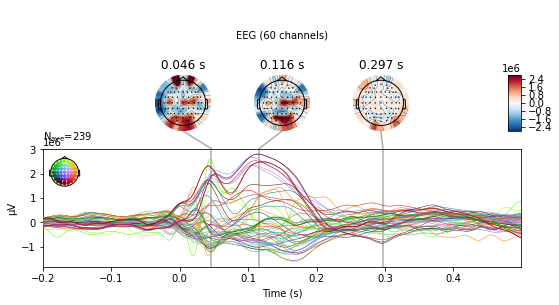

No projector specified for this dataset. Please consider the method self.add_proj.


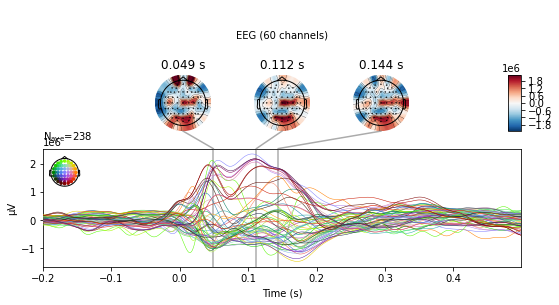

In [6]:
# Face vs Car - topographies and time traces, all channels

face_evoked.plot_joint()
car_evoked.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.


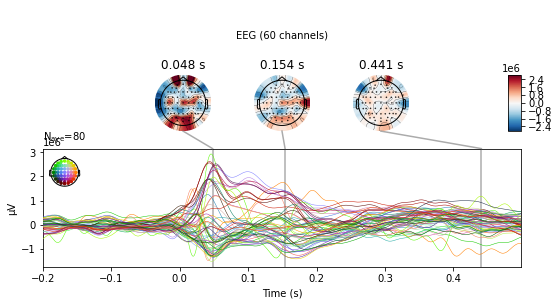

No projector specified for this dataset. Please consider the method self.add_proj.


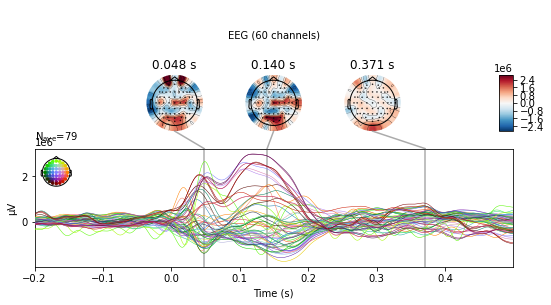

In [7]:
# Easy vs Hard - topographies and time traces, all channels 

easy_evoked.plot_joint()
hard_evoked.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.


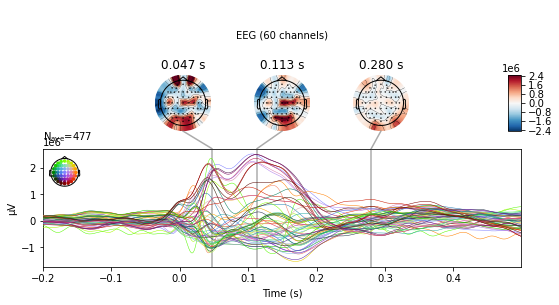

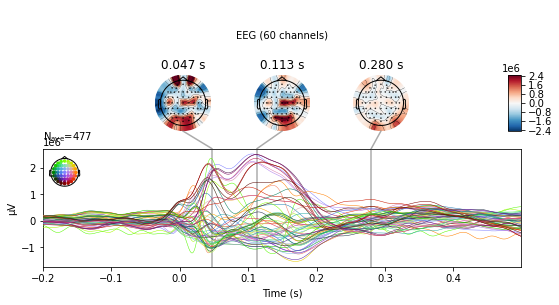

In [8]:
evoked.plot_joint()

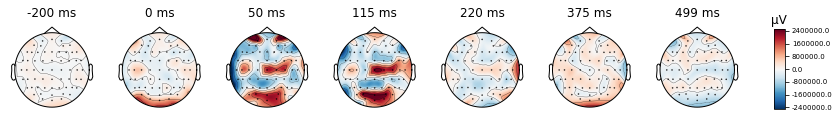

In [9]:
# Plot evoked topographies at times of interest

times = [-0.2, 0, 0.05, 0.115, 0.220, 0.375, 0.499]

evoked.plot_topomap(times, time_unit='ms', outlines='head', extrapolate='box');

### Examine Coherence-Related Differences 

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


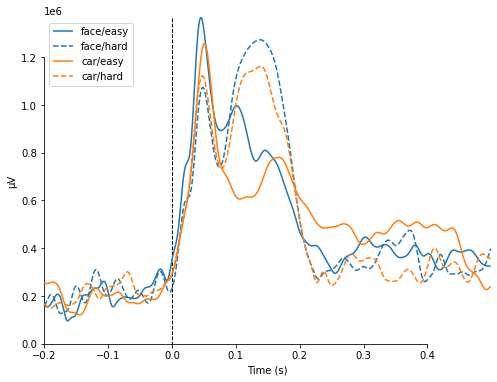

In [10]:
# Compare differences in evoked response by car vs face and coherence levels

face_hard = epochs['face/1'].average()
car_hard = epochs['car/1'].average()

face_easy = epochs['face/6'].average()
car_easy = epochs['car/6'].average()


evokeds_list = face_easy, face_hard, car_easy, car_hard
conds = ('face/easy', 'face/hard', 'car/easy', 'car/hard')
evks = dict(zip(conds, evokeds_list))

mne.viz.plot_compare_evokeds(evks, colors=dict(face=0, car=1),linestyles=dict(easy='solid', hard='dashed'), combine='gfp');

In [11]:
# Average across coherence levels

ev1 = epochs['1'].average()
ev2 = epochs['2'].average()
ev3 = epochs['3'].average()
ev4 = epochs['4'].average()
ev5 = epochs['5'].average()
ev6 = epochs['6'].average()

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


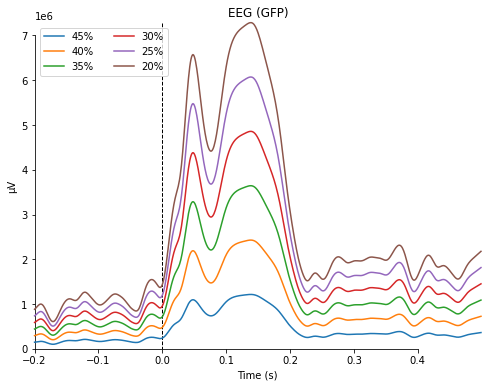

In [12]:
# Compare coherence-related differences in evoked response

evokeds_list = ev1, ev2, ev3, ev4, ev5, ev6
conds = ('45%', '40%', '35%', '30%', '25%', '20%')
evks = dict(zip(conds, evokeds_list))


temp_list = list()
for idx, _comment in enumerate(('45%', '40%', '35%', '30%', '25%', '20%'), start=1):
    _evk = evokeds_list[0].copy()
    _evk.comment = _comment
    _evk.data *= idx  # so we can tell the traces apart
    temp_list.append(_evk)
    
mne.viz.plot_compare_evokeds(temp_list, picks='eeg', combine='gfp');

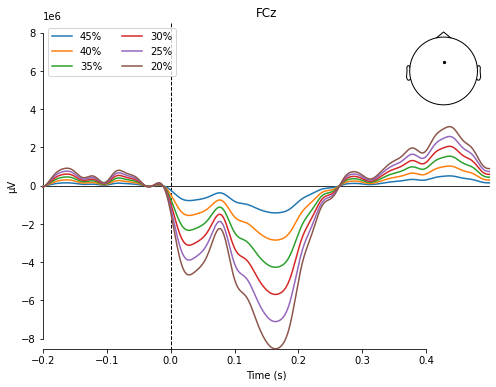

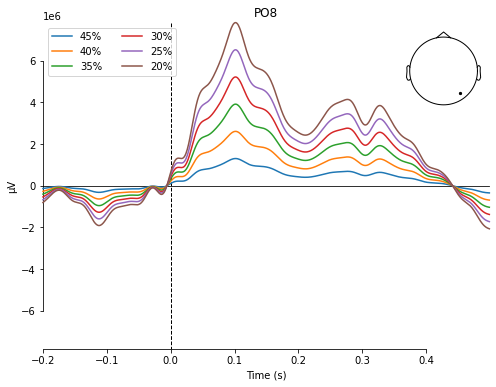

In [13]:
# Visualise coherence-dependent activity at channels of interest

mne.viz.plot_compare_evokeds(temp_list, picks='FCz')
mne.viz.plot_compare_evokeds(temp_list, picks='PO8');

### ICA 
https://mne.tools/0.15/manual/preprocessing/ica.html

In [15]:
#Fit ICA

ica = ICA(n_components=60,max_iter='auto', method='fastica')
ica.fit(epochs)

# method{‘fastica’, ‘infomax’, ‘picard’}

Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 60 components
Fitting ICA took 40.1s.


<ICA | epochs decomposition, fit (fastica): 333900 samples, 60 components, channels used: "eeg">

Not setting metadata
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-16-0f1075244953>:3: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  ica.plot_sources(epochs, show_scrollbars=False);


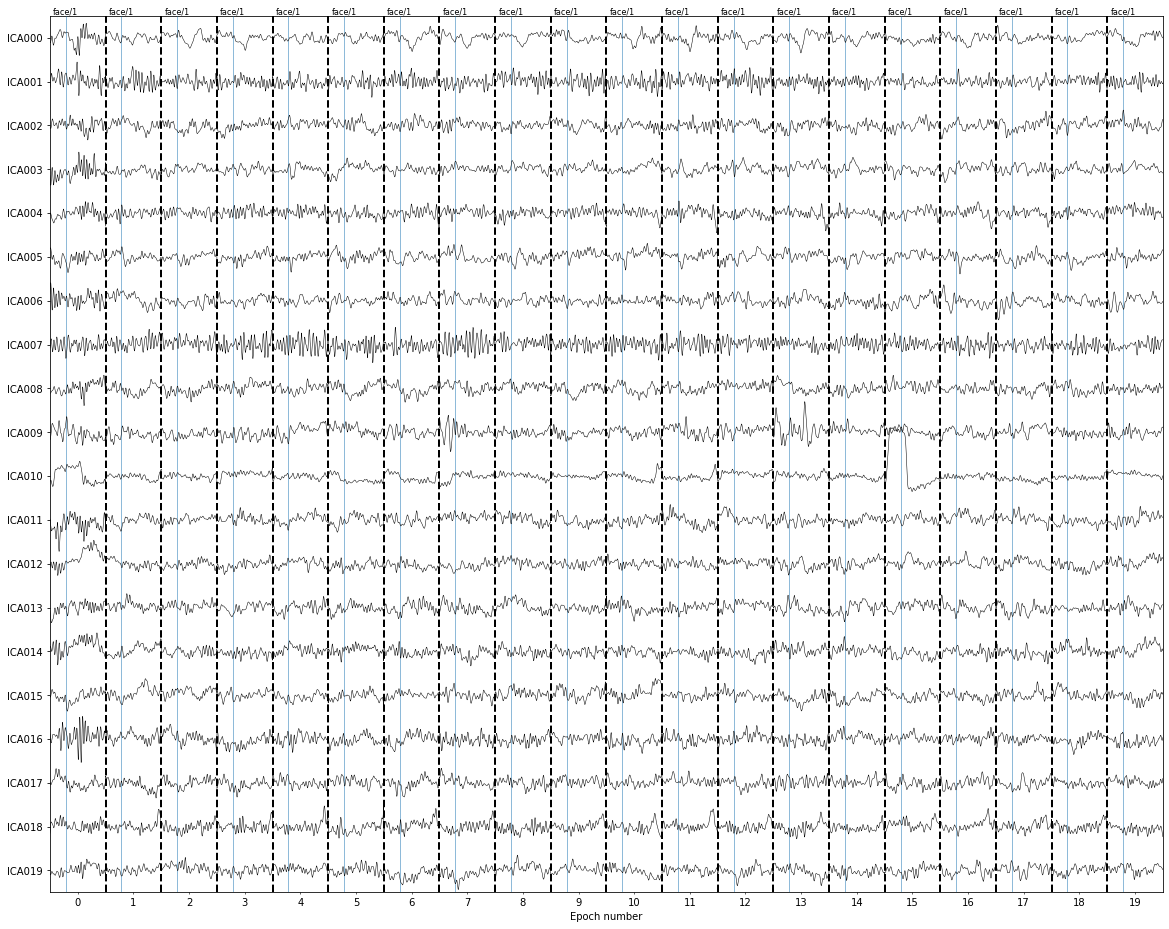

In [16]:
# Plot sources
%matplotlib inline
ica.plot_sources(epochs, show_scrollbars=False);

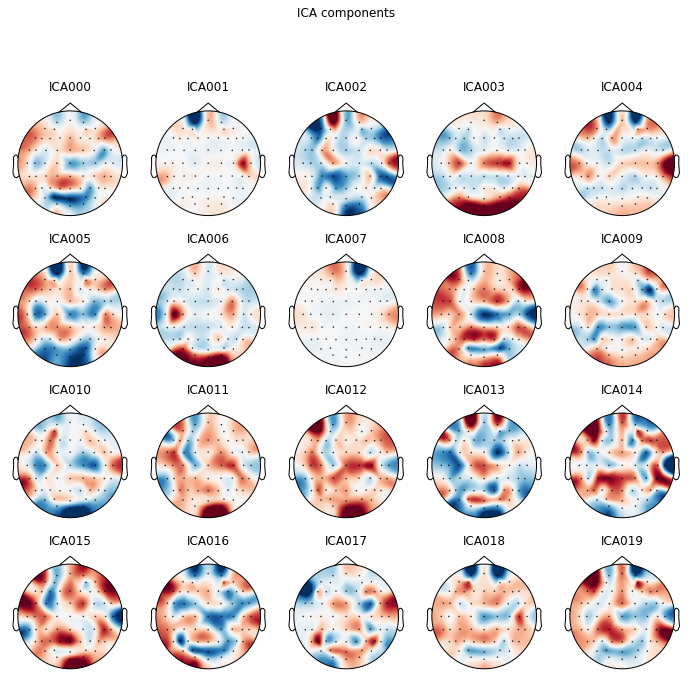

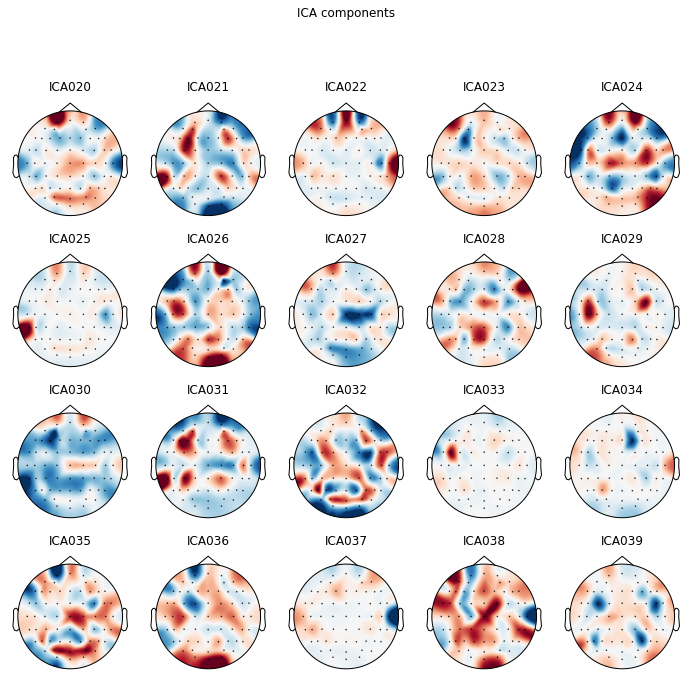

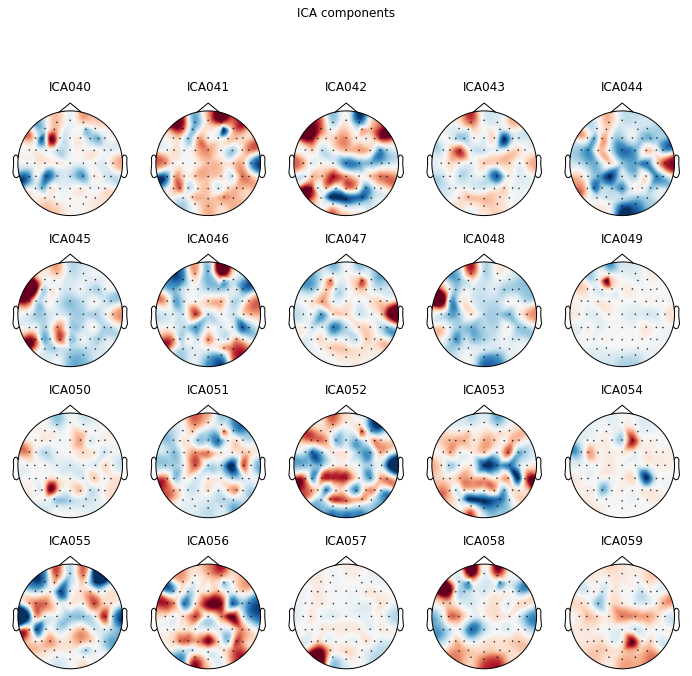

In [20]:
# Plot components

ica.plot_components(contours=0, inst=epochs, plot_std=True);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


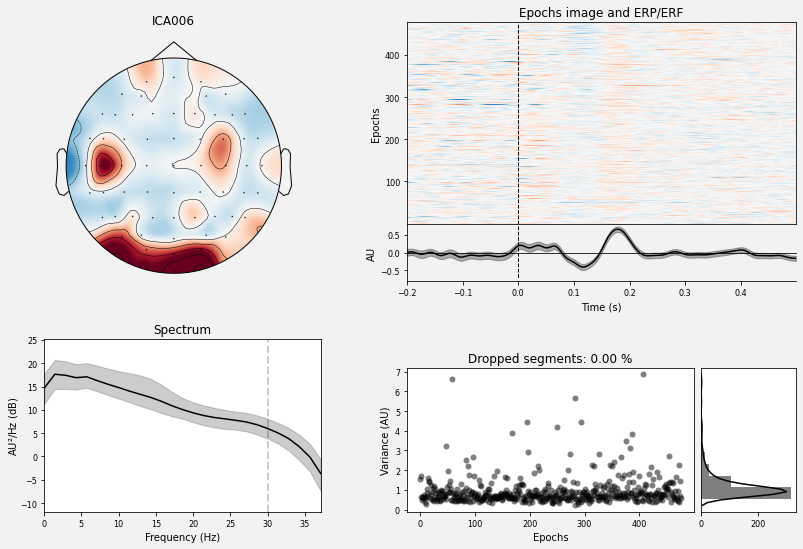

[<Figure size 864x576 with 6 Axes>]

In [21]:
# Plot properties of a selected component

ica.plot_properties(epochs, picks=[6], plot_std=True, figsize=[12, 8])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


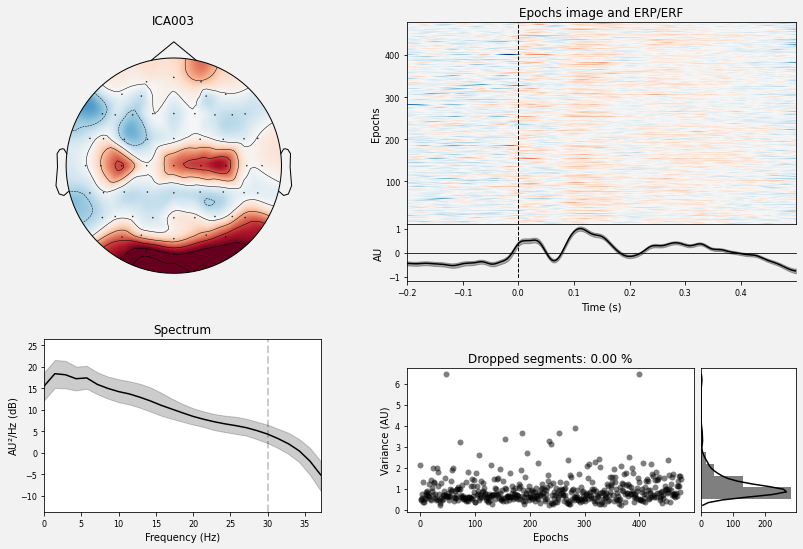

[<Figure size 864x576 with 6 Axes>]

In [19]:
# Plot properties of a selected component

ica.plot_properties(epochs, picks=[3], plot_std=True, figsize=[12, 8])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


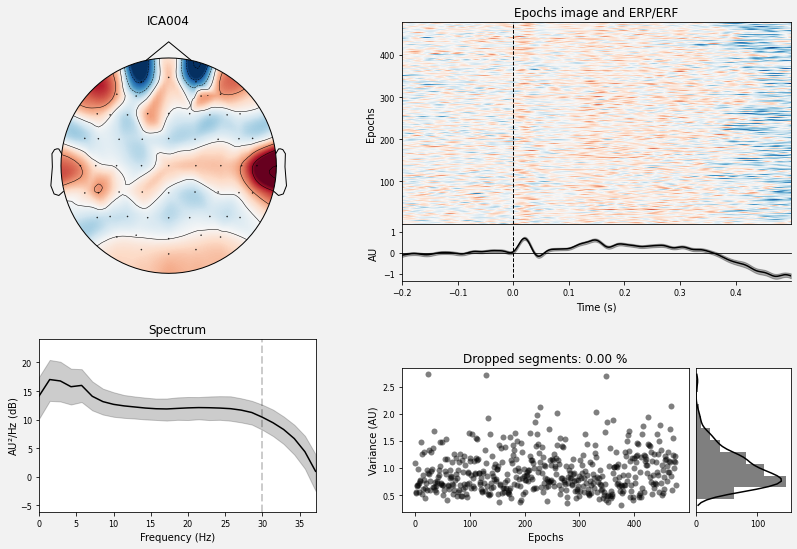

[<Figure size 864x576 with 6 Axes>]

In [23]:
# Plot properties of a selected component

ica.plot_properties(epochs, picks=[4], plot_std=True, figsize=[12, 8])